In [1]:
import pandas as pd
from py2neo import Graph
from pandas import DataFrame


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style(style='darkgrid')

In [2]:
session = Graph("bolt://localhost:7687", auth=("neo4j", "M@hitha863"))

In [3]:
cypher = '''MATCH (permitrec:PermitRecord)-[:IS_OF]->(permittyp:PermitType) 
            RETURN permitrec.PermitRecordId,permitrec.FiledDate,permitrec.IssuedDate,
            permittyp.PermitTypeNum,permittyp.PermitTypeDesc'''
result = session.run(cypher).data()
df = DataFrame(result)
df.head(5)

,permitrec.PermitRecordId,permitrec.FiledDate,permitrec.IssuedDate,permittyp.PermitTypeNum,permittyp.PermitTypeDesc
0,1498197507987,02/23/2018,Not_Available,4,sign - erect
1,1498292106524,02/23/2018,Not_Available,4,sign - erect
2,1498195507987,02/23/2018,Not_Available,4,sign - erect
3,1497850209656,02/21/2018,Not_Available,4,sign - erect
4,1497755420651,02/20/2018,Not_Available,4,sign - erect


In [4]:
df = df.rename(columns =   {'permitrec.PermitRecordId':'PermitRecordId',
                            'permitrec.FiledDate' : 'FiledDate',
                            'permitrec.IssuedDate': 'IssuedDate',
                            'permittyp.PermitTypeNum':'PermitTypeNum',
                            'permittyp.PermitTypeDesc':'PermitTypeDesc'
                            })

In [5]:
#will put NaT(Not a time) for ann Not_Available date times
import traceback
try :
    df['FiledDate'] = pd.to_datetime(df['FiledDate'],errors='coerce')
    df['IssuedDate'] = pd.to_datetime(df['IssuedDate'],errors='coerce')
except :    
    traceback.print_exc()

In [6]:
df.tail(5)

,PermitRecordId,FiledDate,IssuedDate,PermitTypeNum,PermitTypeDesc
198895,1311039101950,2013-07-15,2015-07-15,2,new construction wood frame
198896,1311800491746,2013-07-22,2014-09-18,2,new construction wood frame
198897,131271184340,2013-07-30,2014-08-08,2,new construction wood frame
198898,1312693166414,2013-07-30,2014-03-20,2,new construction wood frame
198899,1313306178277,2013-08-06,2013-08-12,2,new construction wood frame


In [7]:
df = df.assign(wait_time = (df['IssuedDate'] - df['FiledDate']).dt.days)

In [8]:
df['FiledMonth'] = df['FiledDate'].dt.month
df['FiledYear'] = df['FiledDate'].dt.year

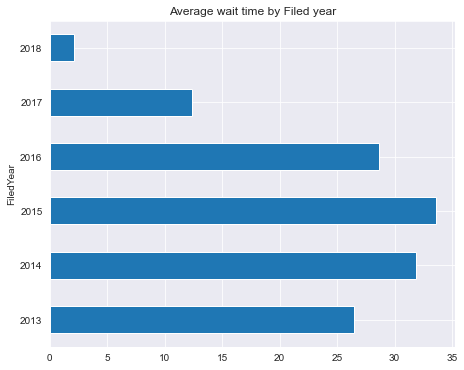

In [12]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
(df.groupby('FiledYear').wait_time.mean()).plot.barh()
plt.title('Average wait time by Filed year')
plt.savefig('myfig')

In [13]:
df_line = df[['FiledYear','wait_time']]
df_line = df_line.groupby(['FiledYear']).agg({'wait_time': ['mean']})
df_line.columns = ['wait_time_mean']
df_line = df_line.reset_index()
df_line

,FiledYear,wait_time_mean
0,2013,26.435542
1,2014,31.836278
2,2015,33.610408
3,2016,28.660499
4,2017,12.421643
5,2018,2.146401


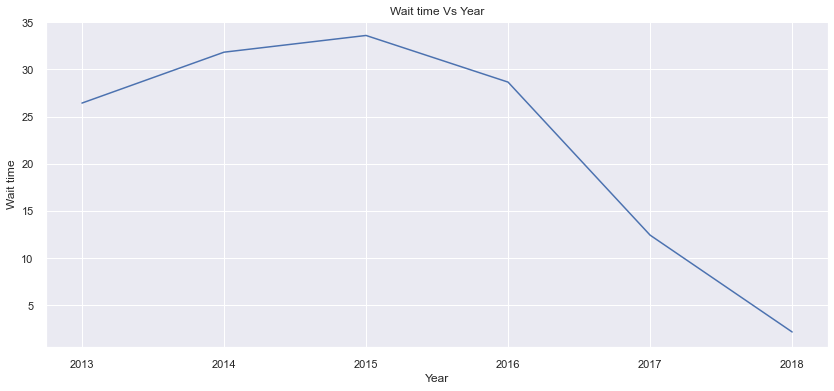

In [140]:
plt.figure(figsize=(14,6))
plt.plot(df_line['FiledYear'], df_line['wait_time_mean'])
plt.title('Wait time Vs Year')
plt.xlabel('Year')
plt.ylabel('Wait time')
plt.savefig('WaitTimeYearLine')
plt.show()

In [ ]:
df_line_month = df[['FiledMonth','FiledYear','wait_time']]
df_line_month = df_line_month.groupby(['FiledMonth', 'FiledYear']).agg({'wait_time': ['mean']})
df_line_month.columns = ['wait_time_mean']
df_line_month = df_line_month.reset_index()
df_line_month

In [ ]:
convert_dict = {'FiledMonth': str,
                'FiledYear': str
               }
  
df_line_month = df_line_month.astype(convert_dict)
df_line_month['Month_Year'] = df_line_month['FiledMonth'].str.cat(df_line_month['FiledYear'],sep="_")
df_line_month

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(df_line_month['Month_Year'], df_line_month['wait_time_mean'])
plt.title('Wait time Vs Year')
plt.xlabel('Month_Year')
plt.ylabel('Wait time')
plt.show()

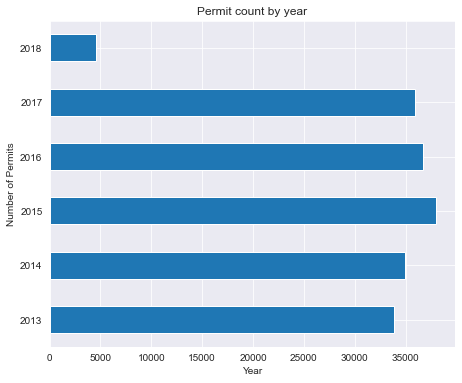

In [20]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,2)
(df.groupby('FiledYear').wait_time.count()).plot.barh()
plt.title('Permit count by year')
plt.xlabel('Year')
plt.ylabel('Number of Permits')
plt.savefig('PermitCountYrBar')

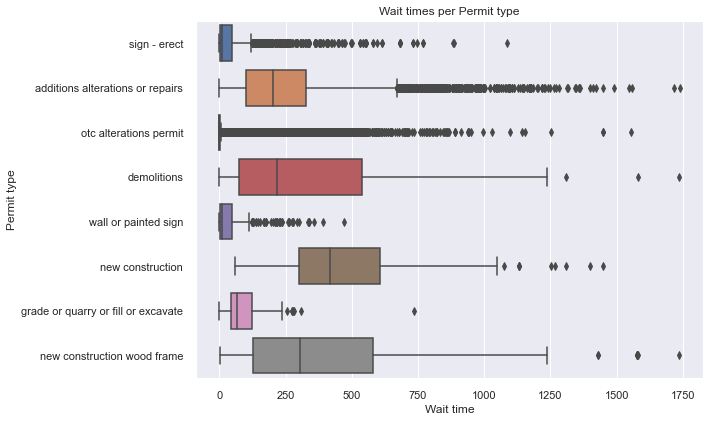

In [138]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(y='PermitTypeDesc', x='wait_time', data = df, orient = 'h');
plt.title('Permit type description vs. wait_time');
plt.tight_layout(pad=1)
plt.title('Wait times per Permit type')
plt.xlabel('Wait time')
plt.ylabel('Permit type')
plt.savefig('PermitTypWtTimeBox')
plt.show()

In [23]:
approvedZipcypher = '''MATCH (permitrec:PermitRecord)-[:IS_CURRENTLY]->(status:CurrentStatus)
,(permitrec)-[:FOR]->(buildprop:BuildingProperty)
where status.CurStatus="filed" OR status.CurStatus="issued" OR status.CurStatus="complete"
RETURN buildprop.Zipcode AS Zipcode,count(permitrec) AS Count, status.CurStatus AS Status'''
approvedZipresult = session.run(approvedZipcypher).data()
approvedZipdf = DataFrame(approvedZipresult)
approvedZipdf

,Zipcode,Count,Status
0,Not_Available,744,complete
1,94131.0,3947,complete
2,94114.0,6168,complete
3,94116.0,3665,complete
4,94110.0,8249,complete
...,...,...,...
79,94132.0,1302,issued
80,94127.0,1701,issued
81,94158.0,444,issued
82,94130.0,32,issued


In [24]:
status = approvedZipdf['Status'].unique()
status= status.tolist()
print(status)
zipCode = approvedZipdf['Zipcode'].unique()
print(zipCode)

['complete', 'filed', 'issued']
['Not_Available' '94131.0' '94114.0' '94116.0' '94110.0' '94112.0'
 '94123.0' '94132.0' '94122.0' '94109.0' '94102.0' '94124.0' '94105.0'
 '94107.0' '94134.0' '94127.0' '94108.0' '94103.0' '94133.0' '94111.0'
 '94121.0' '94115.0' '94117.0' '94104.0' '94118.0' '94158.0' '94130.0'
 '94129.0']


In [79]:
#dict with zipcode as key and number of permit records(count) as value
test={}
for row in approvedZipdf.iterrows():
    idx = status.index(row[1][2])
    key = row[1][0]
    if key in test.keys():
        temp = test[key]
        temp[idx]= row[1][1]
        test[key] = temp
    else:
        new = [0,0,0]
        new[idx]= row[1][1]
        test[key] = new

del test['94129.0']
del test['94130.0']
del test['Not_Available']
test

{'94131.0': [3947, 450, 3054],
 '94114.0': [6168, 725, 6018],
 '94116.0': [3665, 314, 2227],
 '94110.0': [8249, 1254, 7736],
 '94112.0': [4098, 479, 3067],
 '94123.0': [4264, 577, 4345],
 '94132.0': [1947, 163, 1302],
 '94122.0': [4595, 487, 3520],
 '94109.0': [4862, 781, 5374],
 '94102.0': [3233, 492, 3203],
 '94124.0': [2339, 401, 2170],
 '94105.0': [5260, 392, 2850],
 '94107.0': [3918, 512, 3059],
 '94134.0': [1496, 205, 1156],
 '94127.0': [2893, 210, 1701],
 '94108.0': [2473, 389, 2323],
 '94103.0': [5081, 729, 4821],
 '94133.0': [3149, 543, 3480],
 '94111.0': [3213, 253, 1840],
 '94121.0': [3857, 456, 3142],
 '94115.0': [4511, 563, 4756],
 '94117.0': [5339, 798, 5325],
 '94104.0': [2756, 191, 1210],
 '94118.0': [4433, 560, 4500],
 '94158.0': [549, 57, 444]}

In [80]:
# plt configuration parameters
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16.0, 10.0)
results = test
category_names = status
# setup dataframe using the dict provided in the OP
df_plot = pd.DataFrame(results, index=category_names)

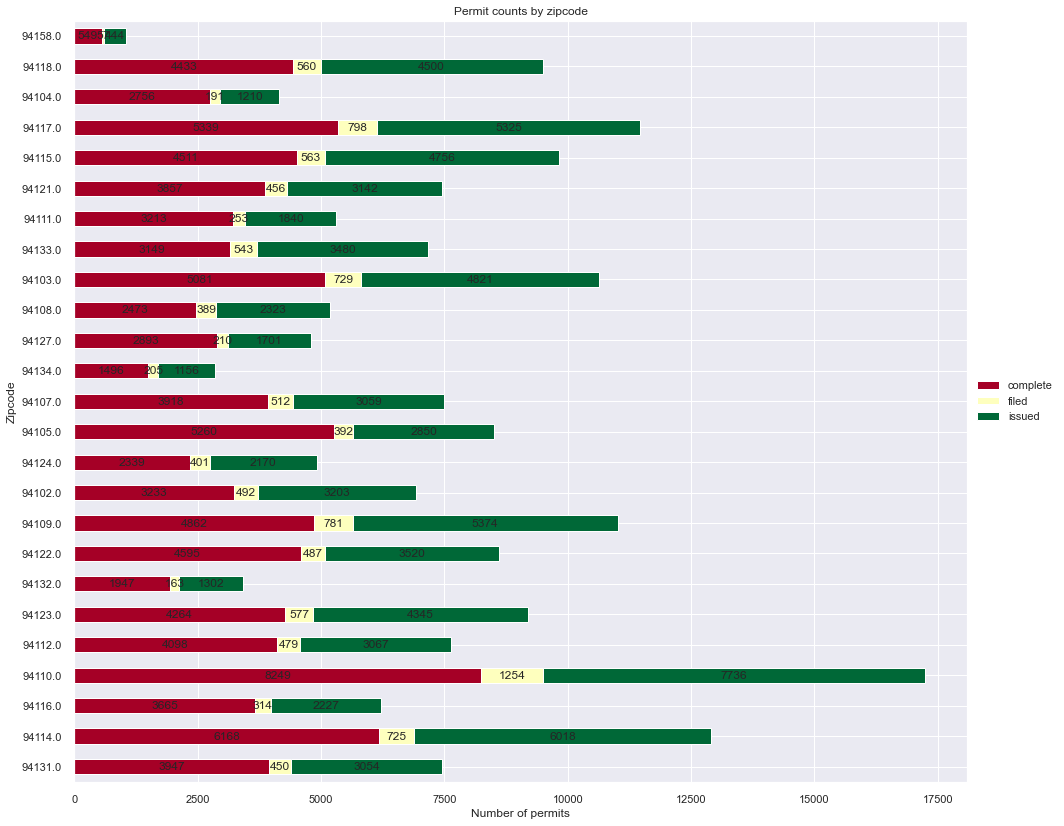

In [137]:
df_plot = df_plot.T


# plot RdYlGn
ax = df_plot.plot.barh(stacked=True, cmap='RdYlGn', figsize=(16, 14))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# annotations:
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    if width > 0:
         ax.annotate(f'{width:0.0f}', xy=(left+width/2, bottom+height/2), ha='center', va='center')

plt.title('Permit counts by zipcode')
plt.xlabel('Number of permits')
plt.ylabel('Zipcode')
plt.savefig('PermitsZipCodeStatus')

In [ ]:
PlanSetCypher = '''MATCH (permitrec:PermitRecord)-[:REPRESENTING]->(planset:PlanSet)
RETURN planset.PlanSetNum AS PlanSetNum, count(permitrec) AS Count'''
planSetResult = session.run(PlanSetCypher).data()
df_plan = DataFrame(planSetResult)
df_plan = df_plan.loc[df_plan["PlanSetNum"] != 'Not_Available']
df_plan = df_plan.loc[df_plan["PlanSetNum"] != '0.0']
df_plan

In [ ]:
plt.pie(df_plan['Count'], labels=df_plan['PlanSetNum'], autopct='%1.1f%%', startangle=140)

plt.axis('equal')
plt.show()

In [125]:
zipPermitTypeWaitcypher = '''MATCH (permitrec:PermitRecord)-[:IS_OF]->(permittyp:PermitType)
,(permitrec)-[:FOR]->(buildprop:BuildingProperty)
RETURN buildprop.Zipcode AS Zipcode,permitrec.FiledDate,permitrec.IssuedDate,
            permittyp.PermitTypeNum,permittyp.PermitTypeDesc'''
zipPermitTypeWaitresult = session.run(zipPermitTypeWaitcypher).data()
zipPermitTypeWaitdf = DataFrame(zipPermitTypeWaitresult)
zipPermitTypeWaitdf.head(5)

,Zipcode,permitrec.FiledDate,permitrec.IssuedDate,permittyp.PermitTypeNum,permittyp.PermitTypeDesc
0,94132.0,02/23/2018,Not_Available,4,sign - erect
1,94121.0,02/23/2018,Not_Available,4,sign - erect
2,94132.0,02/23/2018,Not_Available,4,sign - erect
3,94131.0,02/21/2018,Not_Available,4,sign - erect
4,94115.0,02/20/2018,Not_Available,4,sign - erect


In [126]:
zipPermitTypeWaitdf = zipPermitTypeWaitdf.rename(columns =   {
                            'permitrec.FiledDate' : 'FiledDate',
                            'permitrec.IssuedDate': 'IssuedDate',
                            'permittyp.PermitTypeNum':'PermitTypeNum',
                            'permittyp.PermitTypeDesc':'PermitTypeDesc'
                            })

In [127]:
#will put NaT(Not a time) for ann Not_Available date times
import traceback
try :
    zipPermitTypeWaitdf['FiledDate'] = pd.to_datetime(zipPermitTypeWaitdf['FiledDate'],errors='coerce')
    zipPermitTypeWaitdf['IssuedDate'] = pd.to_datetime(zipPermitTypeWaitdf['IssuedDate'],errors='coerce')
except :    
    traceback.print_exc()
    
zipPermitTypeWaitdf.tail(10)

,Zipcode,FiledDate,IssuedDate,PermitTypeNum,PermitTypeDesc
198890,94118.0,2013-06-14,2015-12-11,2,new construction wood frame
198891,94121.0,2013-06-21,2015-03-24,2,new construction wood frame
198892,94121.0,2013-06-21,2015-03-24,2,new construction wood frame
198893,94110.0,2013-06-25,2014-02-12,2,new construction wood frame
198894,94109.0,2013-07-02,2015-12-10,2,new construction wood frame
198895,94121.0,2013-07-15,2015-07-15,2,new construction wood frame
198896,94122.0,2013-07-22,2014-09-18,2,new construction wood frame
198897,94123.0,2013-07-30,2014-08-08,2,new construction wood frame
198898,94103.0,2013-07-30,2014-03-20,2,new construction wood frame
198899,94124.0,2013-08-06,2013-08-12,2,new construction wood frame


In [ ]:
zipPermitTypeWaitdf = zipPermitTypeWaitdf.assign(wait_time = (zipPermitTypeWaitdf['IssuedDate'] - zipPermitTypeWaitdf['FiledDate']).dt.days)

zipPermitTypeWaitdf= zipPermitTypeWaitdf[['Zipcode','PermitTypeDesc','wait_time']]

In [132]:
zipPermitTypeWaitdf.tail(5)

,Zipcode,PermitTypeDesc,wait_time
198895,94121.0,new construction wood frame,730.0
198896,94122.0,new construction wood frame,423.0
198897,94123.0,new construction wood frame,374.0
198898,94103.0,new construction wood frame,233.0
198899,94124.0,new construction wood frame,6.0


In [133]:
zipPermitTypeWaitdf = zipPermitTypeWaitdf.groupby(['Zipcode', 'PermitTypeDesc']).agg({'wait_time': ['mean']})
zipPermitTypeWaitdf.columns = ['Wait_time_mean']
zipPermitTypeWaitdf = zipPermitTypeWaitdf.reset_index()
zipPermitTypeWaitdf=zipPermitTypeWaitdf.fillna(-1.0)
zipPermitTypeWaitdf

,Zipcode,PermitTypeDesc,Wait_time_mean
0,94102.0,additions alterations or repairs,204.964623
1,94102.0,demolitions,275.740741
2,94102.0,grade or quarry or fill or excavate,278.000000
3,94102.0,new construction,535.380952
4,94102.0,new construction wood frame,376.250000
...,...,...,...
197,Not_Available,demolitions,263.000000
198,Not_Available,new construction,-1.000000
199,Not_Available,otc alterations permit,6.772409
200,Not_Available,sign - erect,27.636364


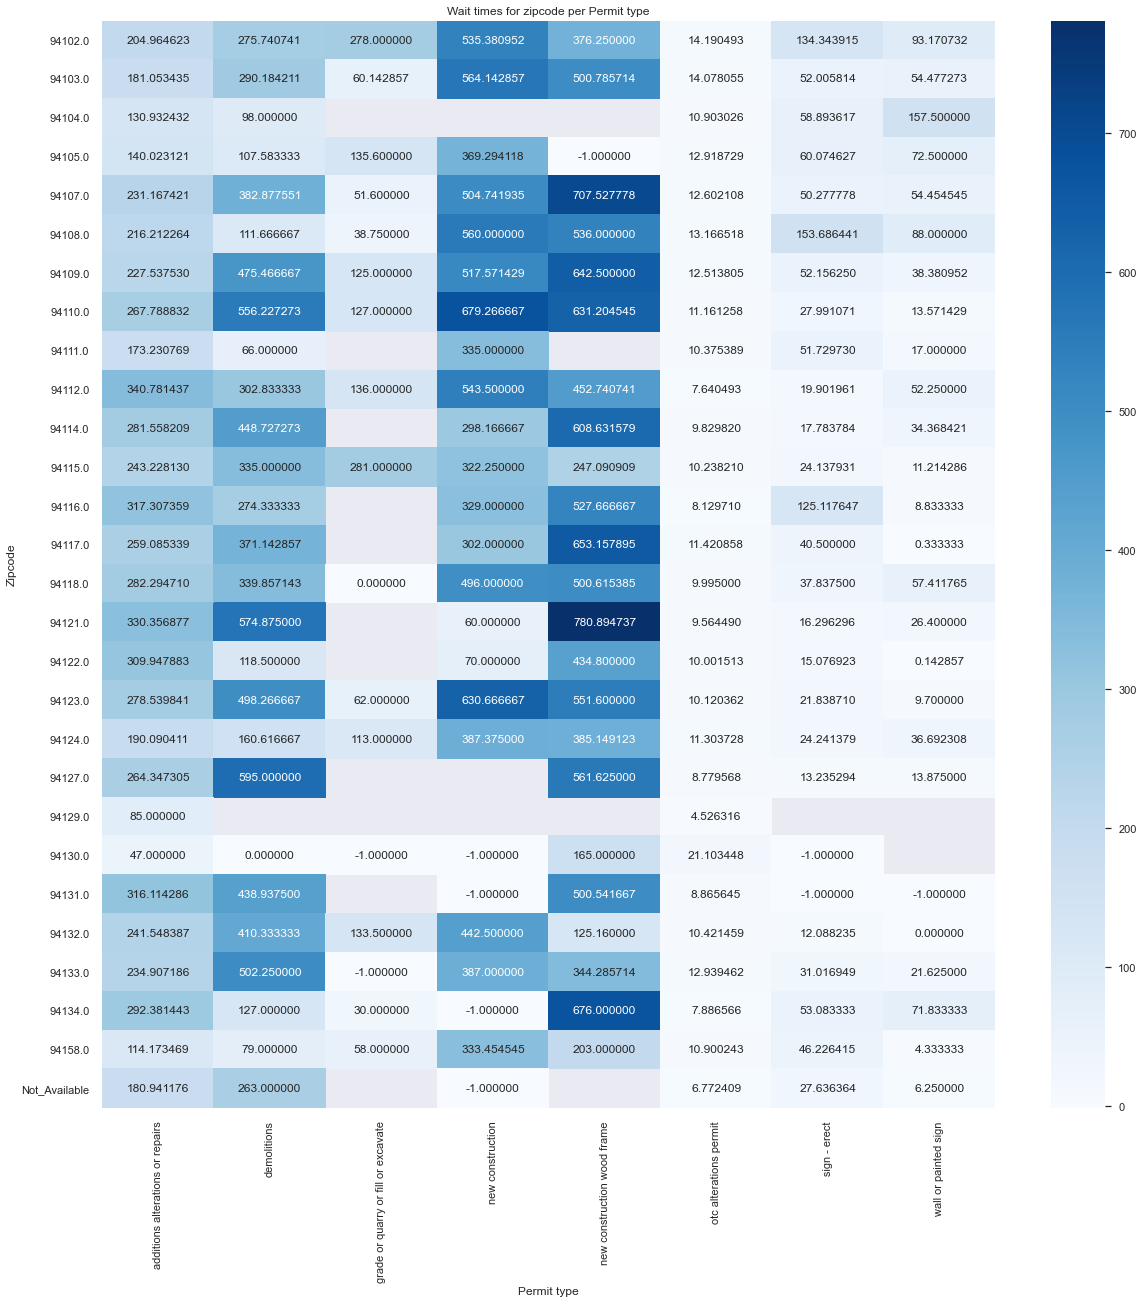

In [135]:
import seaborn as sns; sns.set_theme()

flights = zipPermitTypeWaitdf.pivot("Zipcode", "PermitTypeDesc", "Wait_time_mean")
f, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(flights, annot=True, fmt="f", cmap="Blues")

plt.title('Wait times for zipcode per Permit type')
plt.xlabel('Permit type')
plt.ylabel('Zipcode')
plt.savefig('ZipPermitWait')